In [1]:
#First let's import some packages
import xarray as xr
import numpy as np
from xgcm.grid import Grid
import xrft
from dask.diagnostics import ProgressBar
from matplotlib import pyplot as plt

In [2]:
unfiltered_vels = xr.open_zarr('/swot/SUM03/spencer/time_1/unfiltered_vels.zarr')
filtered_vels = xr.open_zarr('/swot/SUM03/spencer/time_1/filtered_vels.zarr')
eul_filtered_vels = xr.open_zarr('/swot/SUM03/spencer/time_1/eulfiltered_vels.zarr')

In [22]:
unfiltered_eta = xr.open_zarr('/swot/SUM03/spencer/time_1/unfiltered_eta_nom.zarr')
eta_mean = xr.open_zarr('/swot/SUM02/spencer/swot_agulhas_surf/eta_mean.zarr')

unfiltered_eta = unfiltered_eta.eta+eta_mean.Eta

unfiltered_u = unfiltered_vels.u.isel(time=slice(1,2000))
unfiltered_v = unfiltered_vels.v.isel(time=slice(1,2000))

filtered_u = filtered_vels.u.isel(time=slice(1,2000))
filtered_v = filtered_vels.v.isel(time=slice(1,2000))

eulfiltered_u = eul_filtered_vels.u_eulfiltered
eulfiltered_v = eul_filtered_vels.v_eulfiltered

In [23]:
DXC =np.fromfile('/swot/SUM01/spencer/swot_agulhas_test/DXC.data', dtype='>f4')
DYC =np.fromfile('/swot/SUM01/spencer/swot_agulhas_test/DYC.data', dtype='>f4')
DXC_array = (xr.DataArray(DXC.reshape(2160,2160),dims=['j','i']).assign_coords(i=unfiltered_eta.i,j=unfiltered_eta.j))
DYC_array = (xr.DataArray(DYC.reshape(2160,2160),dims=['j','i']).assign_coords(i=unfiltered_eta.i,j=unfiltered_eta.j))

In [29]:
grid = Grid(unfiltered_vels, coords={'X': {'center': 'i', 'left': 'i_g'}, 'Y': {'center': 'j', 'left': 'j_g'}})

In [30]:
YC =np.fromfile('/swot/SUM01/spencer/swot_agulhas_test/YC.data', dtype='>f4')
f = 2*2*np.pi/24/3600*np.sin(YC.reshape(2160,2160)*np.pi/180)
f_array = (xr.DataArray(f,dims=['j','i']).assign_coords(i=unfiltered_eta.i,j=unfiltered_eta.j))

In [31]:
g=9.81

u_g = (-g/f*grid.interp(grid.diff(unfiltered_eta,'Y'),'Y')/DYC_array)
v_g = (g/f*grid.interp(grid.diff(unfiltered_eta,'X'),'X')/DXC_array)

In [34]:
last_time=90


unfiltered_speed = (unfiltered_u.isel(time=slice(0,last_time))**2 
                    + unfiltered_v.isel(time=slice(0,last_time))**2)**0.5

filtered_speed = (filtered_u.isel(time=slice(0,last_time))**2 
                    + filtered_v.isel(time=slice(0,last_time))**2)**0.5

eulfiltered_speed = (eulfiltered_u.isel(time=slice(0,last_time))**2 
                    + eulfiltered_v.isel(time=slice(0,last_time))**2)**0.5

geostrophic_speed = (u_g.isel(time=slice(0,last_time))**2 
                    + v_g.isel(time=slice(0,last_time))**2)**0.5

unfiltered_minus_g = unfiltered_speed - geostrophic_speed

In [41]:
#ffmpeg -r 60 -f image2 -i fig%03d.jpg -vcodec libx264 -crf 25 -pix_fmt yuv420p vel.mp4

for tt in range(0,70):
    plt.figure(figsize=(9,3.75))
    
    plt.subplot(121)
    unfiltered_speed.isel(time=tt).plot.pcolormesh(x='i',y='j',levels=np.arange(0,1,0.05),cmap='inferno')
    plt.title('Unfiltered speed, time = ' + '{0:.1f}'.format((unfiltered_speed.time.values[tt]-unfiltered_speed.time.values[0])/3600/24)+ 'days')
    
    plt.subplot(122)
    unfiltered_minus_g.isel(time=tt).plot.pcolormesh(x='i',y='j',levels=np.arange(-1,1,0.05))
    plt.title('Unfiltered speed minus geostrophic speed, time = ' + '{0:.1f}'.format((unfiltered_speed.time.values[tt]-unfiltered_speed.time.values[0])/3600/24)+ 'days')
    plt.tight_layout()
    fig = plt.gcf()
    fig.savefig("/home/spencerj/agulhas-offline/movie/vel/fig{:03d}.jpg".format(tt),dpi=200)
    plt.close(fig) 

Text(0.5, 1.0, 'Lagrangian filtered speed, time = 0.0days')

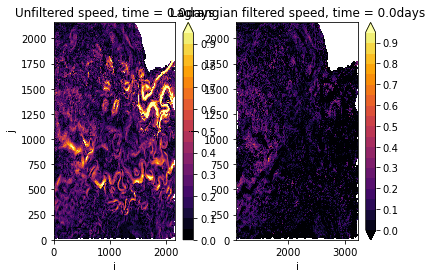

In [38]:

tt=1
plt.subplot(121)
unfiltered_speed.isel(time=tt).plot.pcolormesh(x='i',y='j',levels=np.arange(0,1,0.05),cmap='inferno')
plt.title('Unfiltered speed, time = ' + '{0:.1f}'.format((unfiltered_speed.time.values[tt]-unfiltered_speed.time.values[0])/3600/24)+ 'days')
    
plt.subplot(122)
unfiltered_minus_g.isel(time=tt).plot.pcolormesh(x='i',y='j',levels=np.arange(0,1,0.05),cmap='inferno')
plt.title('Lagrangian filtered speed, time = ' + '{0:.1f}'.format((unfiltered_speed.time.values[tt]-unfiltered_speed.time.values[0])/3600/24)+ 'days')

<xarray.Dataset>
Dimensions:  (i: 2160, j: 2160)
Coordinates:
    face     int64 ...
  * i        (i) int64 1080 1081 1082 1083 1084 ... 3235 3236 3237 3238 3239
  * j        (j) float64 0.0 1.0 2.0 3.0 ... 2.157e+03 2.158e+03 2.159e+03
    x        (j, i) float32 dask.array<chunksize=(270, 540), meta=np.ndarray>
    y        (j, i) float32 dask.array<chunksize=(270, 540), meta=np.ndarray>
Data variables:
    Eta      (j, i) float32 dask.array<chunksize=(270, 540), meta=np.ndarray>